In [2]:
# %load filter.py
import pandas
import numpy as np
from mne.io import read_raw_bdf
from mne.filter import notch_filter

# raw data
dat = read_raw_bdf("../Data/Subject_1-1.bdf")
print(dat.info)
dat.plot()

# use EEG channel 1 to test
# eeg1 = dat.to_data_frame("EEG 1")

# apply notch filter, not sure about the parameters
# notch_filter(eeg1.values, 250, np.arange(60, 121, 60))


Extracting EDF parameters from /root/Desktop/EEG-Preprocessing/Data/Subject_1-1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG 1, EEG 2, EEG 3, EEG 4, EEG 5, EEG 6, EEG 7, EEG 8, ...
    chs : list | 11 items (EEG: 11)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 125.0 Hz
    meas_date : tuple | 2019-06-13 01:28:09 GMT
    nchan : int | 11
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 250.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : N

<Figure size 640x480 with 4 Axes>

<Figure size 640x480 with 4 Axes>

Using default location ~/mne_data for somato...
Creating ~/mne_data
[........................................] 100.00% (625.1 MB,  35.9 MB/s) |   
Verifying hash 77a7601948c9e38d2da52446e2eab10f.
Decompressing the archive: /root/mne_data/MNE-somato-data.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/root/mne_data/MNE-somato-data']
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Opening raw data file /root/mne_data/MNE-somato-data/MEG/somato/sef_raw_sss.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
Current compensation grade : 0
111 events found
Event IDs: [1]
Opening raw data file /root/mne_data/MNE-somato-data/MEG/somato/sef_raw_sss.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
Current compensation grade : 0
Reading 0 ... 269399  =      0.000 ...   897.077 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filt

/usr/lib/python3/dist-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


111 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 111 events and 1202 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
3 bad epochs dropped
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: EOG 061
[done]
108 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Opening raw data file /root/mne_data/MNE-somato-data/MEG/somato/sef_raw_sss.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
Current compensation grade : 0
Reading 0 ... 269399  =      0.000 ...   897.077 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass fil

Text(0.5,0,'Time [ms]')

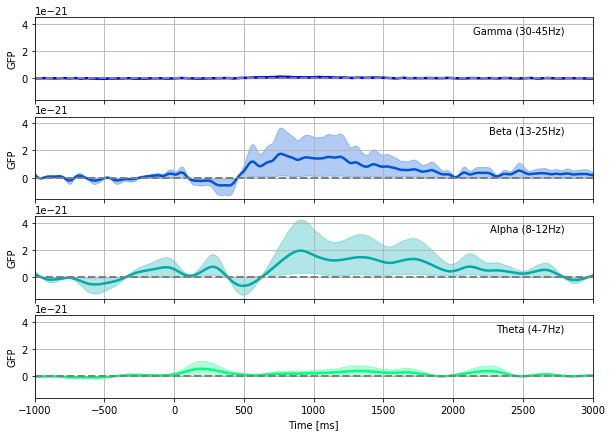

In [5]:
# %load example.py
# https://www.martinos.org/mne/stable/auto_examples/time_frequency/plot_time_frequency_global_field_power.html?highlight=bandpass%20filter
# Explore event-related dynamics for specific frequency bands

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import somato
from mne.baseline import rescale
from mne.stats import _bootstrap_ci

data_path = somato.data_path()
raw_fname = data_path + '/MEG/somato/sef_raw_sss.fif'

# let's explore some frequency bands
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

# set epoching parameters
event_id, tmin, tmax = 1, -1., 3.
baseline = None

# get the header to extract events
raw = mne.io.read_raw_fif(raw_fname, preload=False)
events = mne.find_events(raw, stim_channel='STI 014')

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw = mne.io.read_raw_fif(raw_fname, preload=True)
    raw.pick_types(meg='grad', eog=True)  # we just look at gradiometers

    # bandpass filter and compute Hilbert
    raw.filter(fmin, fmax, n_jobs=1,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1,  # in each band and skip "auto" option.
               fir_design='firwin')
    raw.apply_hilbert(n_jobs=1, envelope=False)

    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline,
                        reject=dict(grad=4000e-13, eog=350e-6), preload=True)
    # remove evoked response and get analytic signal (envelope)
    epochs.subtract_evoked()  # for this we need to construct new epochs.
    epochs = mne.EpochsArray(
        data=np.abs(epochs.get_data()), info=epochs.info, tmin=epochs.tmin)
    # now average and move on
    frequency_map.append(((band, fmin, fmax), epochs.average()))

fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = _bootstrap_ci(average.data, random_state=0,
                                  stat_fun=lambda x: np.sum(x ** 2, axis=0))
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')

